# Day 9
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, reflection and rotation augmentation

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [57]:
class RotationReflectionBatch(BatchYielder):
    def __init__(self, header, datafile=None, augRotMult=4, trainTimeAug=True, testTimeAug=True):
        self.header = header
        self.augmented = True
        self.augRotMult = augRotMult
        self.augMult = self.augRotMult*4
        self.trainTimeAug = trainTimeAug
        self.testTimeAug = testTimeAug
        if not isinstance(datafile, types.NoneType):
            self.addSource(datafile)
    
    @staticmethod
    def rotate(inData, vectors):
        for vector in vectors:
            inData.loc[:, vector + '_px'] = inData.loc[:, vector + '_px']*np.cos(inData.loc[:, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[:, 'aug_angle'])
            inData.loc[:, vector + '_py'] = inData.loc[:, vector + '_py']*np.cos(inData.loc[:, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[:, 'aug_angle'])
    
    @staticmethod
    def reflect(inData, vectors):
        for vector in vectors:
            for coord in ['_px', '_pz']:
                try:
                    inData.loc[inData['aug' + coord] == 1, vector + coord] = -inData.loc[inData['aug' + coord] == 1, vector + coord]
                except KeyError:
                    pass
            
    def getBatch(self, index, datafile=None):
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])

        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        vectors = [x[:-3] for x in inputs.columns if '_px' in x]
        inputs['aug_angle'] = 2*np.pi*np.random.random(size=len(inputs))
        for coord in ['_px', '_pz']:
            inputs['aug' + coord] = np.random.randint(0, 2, size=len(inputs))
        self.rotate(inputs, vectors)
        self.reflect(inputs, vectors)
        
        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}
    
    def getTestBatch(self, index, augIndex, datafile=None):
        if augIndex >= self.augMult:
            print "Invalid augmentation index passed", augIndex
            return -1
        
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])
            
        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        rotIndex = augIndex%self.augRotMult
        refIndex = '{0:02b}'.format(int(augIndex/4))
        vectors = [x[:-3] for x in inputs.columns if '_px' in x]
        inputs['aug_angle'] = np.linspace(0, 2*np.pi, (self.augRotMult)+1)[rotIndex]
        for i, coord in enumerate(['_px', '_pz']):
            inputs['aug' + coord] = int(refIndex[i])
        self.rotate(inputs, vectors)
        self.reflect(inputs, vectors)

        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}

In [58]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"))
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.229s 


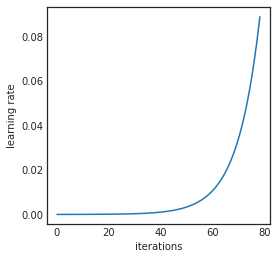

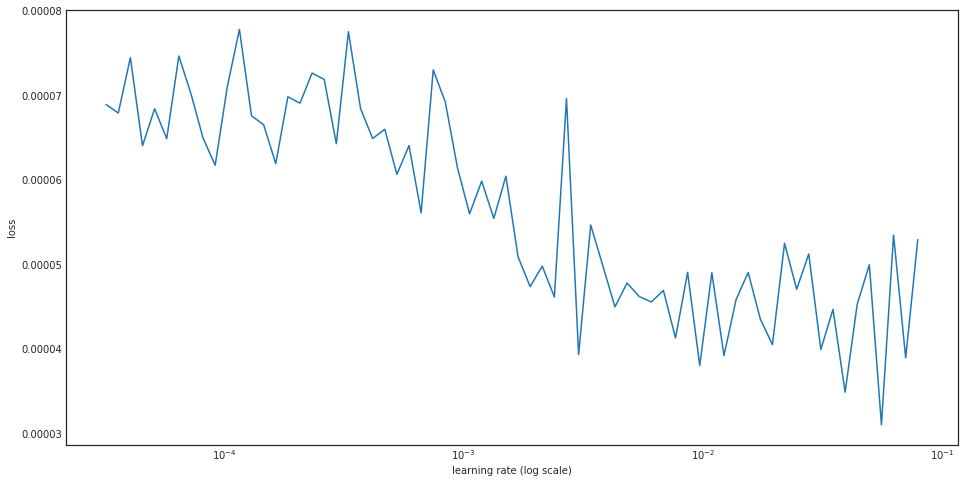

______________________________________



In [59]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

In [60]:
compileArgs['lr'] = 1e-3

## Train classifier

In [ ]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          patience=2, cosAnnealMult=2, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 4.4283700067e-05
2 New best found: 3.92413603924e-05
3 New best found: 3.8136331588e-05
4 New best found: 3.76118607045e-05
5 New best found: 3.66991365834e-05
6 New best found: 3.65648081643e-05
7 New best found: 3.62912261731e-05
9 New best found: 3.59634010658e-05
10 New best found: 3.57225122846e-05
11 New best found: 3.55747691999e-05
12 New best found: 3.5280910456e-05
13 New best found: 3.50571040309e-05
19 New best found: 3.49350544745e-05
23 New best found: 3.46378303685e-05
25 New best found: 3.45670017287e-05
26 New best found: 3.45202360361e-05
27 New best found: 3.44955552434e-05
28 New best found: 3.44067859261e-05
30 New best found: 3.43423835319e-05
31 New best found: 3.41905804161e-05
42 New best found: 3.41592612905e-05
43 New best found: 3.41253441406e-05
45 New best found: 3.4043416199e-05
48 New best found: 3.39002235063e-05
49 New best found

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

In [ ]:
np.mean([3.110186173813499e-05,
3.149156671751852e-05,
3.158000014466575e-05,
3.163253870031559e-05,
3.169450663676961e-05,
3.192054898237487e-05,
3.203069043982587e-05,
3.269235153926564e-05,
3.29240844411122e-05,
3.2976034126695485e-05])

## Response on development data

In [ ]:
def batchEnsemblePredict(ensemble, weights, data, predName='pred', nOut=1, outputPipe=None, ensembleSize=None, nFolds=-1, verbose=False):
    if isinstance(ensembleSize, types.NoneType):
        ensembleSize = len(ensemble)

    if not isinstance(data, BatchYielder):
        data = BatchYielder(data)

    if nFolds < 0:
        nFolds = len(data.source)

    for fold in range(nFolds):
        if verbose:
            print 'Predicting batch {} out of {}'.format(fold+1, nFolds)
            start = timeit.default_timer()

        if not data.testTimeAug:
            batch = data.getBatch(fold)['inputs']
            batchPred = ensemblePredict(batch, ensemble, weights, n=ensembleSize, nOut=nOut, outputPipe=outputPipe)

        else:
            tmpPred = []
            for aug in range(data.augMult):
                batch = data.getTestBatch(fold, aug)['inputs']
                tmpPred.append(ensemblePredict(batch, ensemble, weights, n=ensembleSize, nOut=nOut, outputPipe=outputPipe))
            batchPred = np.mean(tmpPred, axis=0)

        if verbose: 
            print "Prediction took {}s per sample\n".format((timeit.default_timer() - start)/len(batch))

        if nOut > 1:
            saveBatchPred(batchPred, 'fold_' + str(fold), data.source, predName=predName)
        else:
            saveBatchPred(batchPred[:,0], 'fold_' + str(fold), data.source, predName=predName)

In [ ]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

In [ ]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source)),
                                                            roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source), sample_weight=getFeature('weights', trainData.source)))

## Response on val data

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

## Evaluation

### Import in dataframe

In [ ]:
valframe = convertToDF(valData.source)

In [ ]:
sigVal = (valframe.gen_target == 1)
bkgVal = (valframe.gen_target == 0)

### MVA distributions

In [ ]:
getClassPredPlot([valframe[bkgVal], valframe[sigVal]], weightName='gen_weight')

In [ ]:
valframe['ams'] = amsScan(valframe)[0]

In [ ]:
bests = foldAMSScan(valframe, 10)

In [ ]:
batchEnsemblePredict(ensemble, weights, RotationBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+")), ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.96, 'Day_9_96')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_9_96_test.csv -m"Day_9 1e-3 96"